In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv")
df.head()



,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [6]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 5


summarise the statistical properties of the columns:

In [7]:

# describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


In [8]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing


,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [ ]:
# none missing which is great

In [9]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


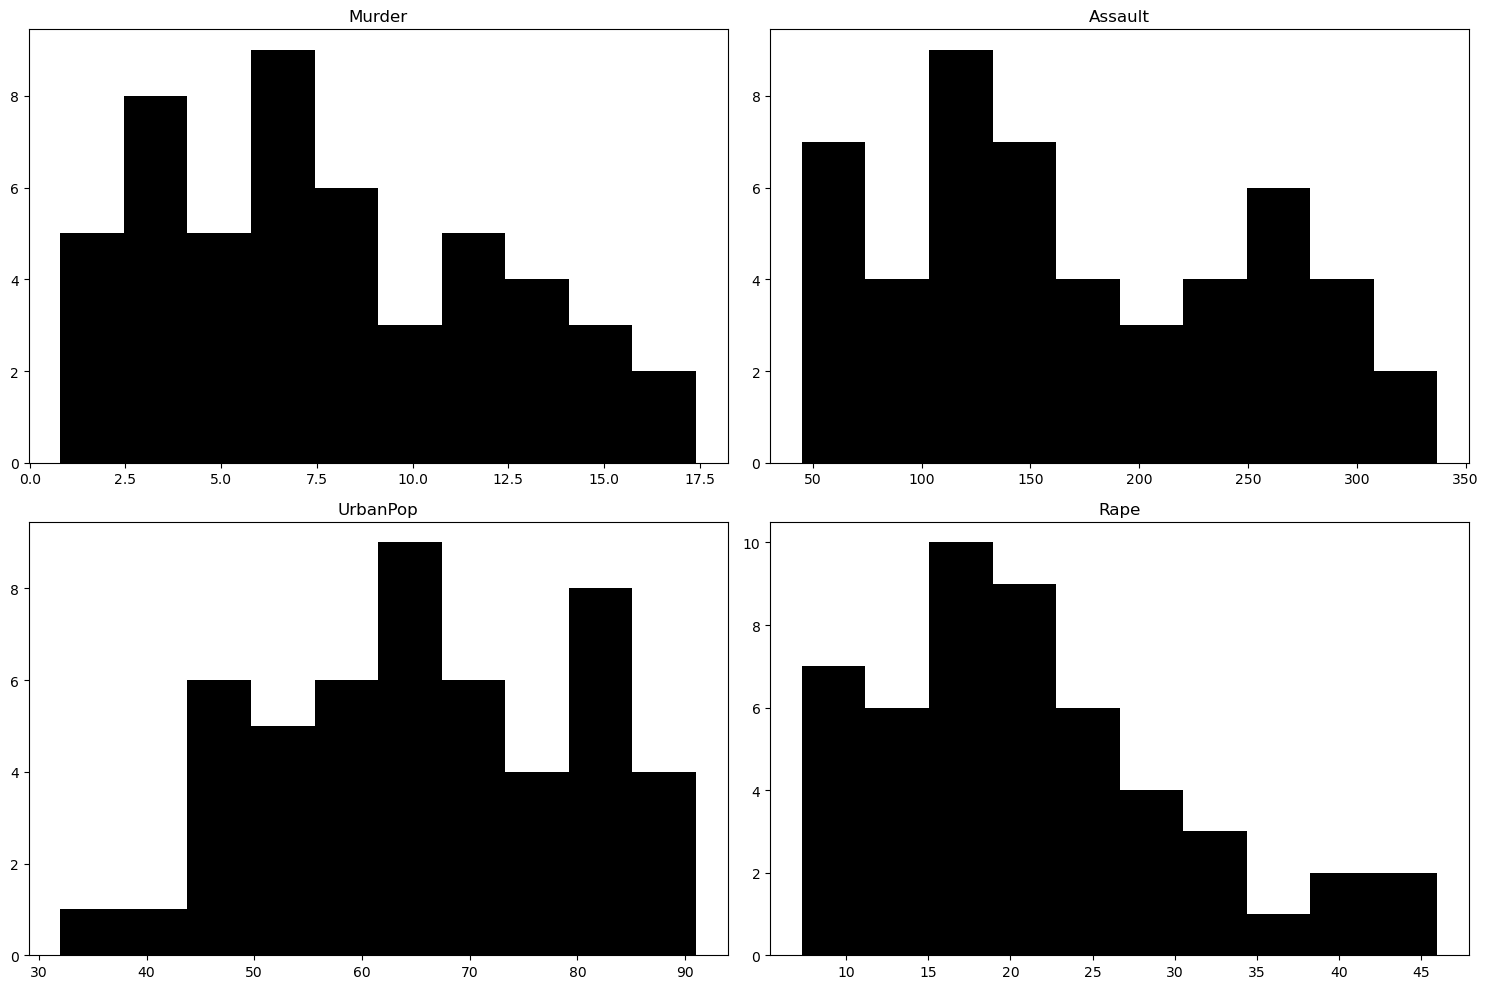

In [10]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) 
plt.tight_layout()
plt.show()


In [11]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary

,missing,mean,std,min,max
City,0,NaN,NaN,NaN,NaN
Murder,0,7.788,4.355510,0.8,17.4
Assault,0,170.760,83.337661,45.0,337.0
UrbanPop,0,65.540,14.474763,32.0,91.0
Rape,0,21.232,9.366385,7.3,46.0


At first glance, the Assault variable stands out as having a mean and standard deviation which is dramatically higher than the other variables. This makes sense as some of the other variables are percentages or ratios per 1000 people while assault is in count. This indicates that scaling the data will be useful to keep the assault figures from impacting the analysis disproportionately

In [ ]:
#  we have no missing values - so will skip KNN imputation

In [34]:
countries = df.index
corr_df = df.drop(["City"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

/var/folders/4s/4zq592453wxdckfkxpndd_z40000gn/T/ipykernel_3823/1967637567.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)


<AxesSubplot:>

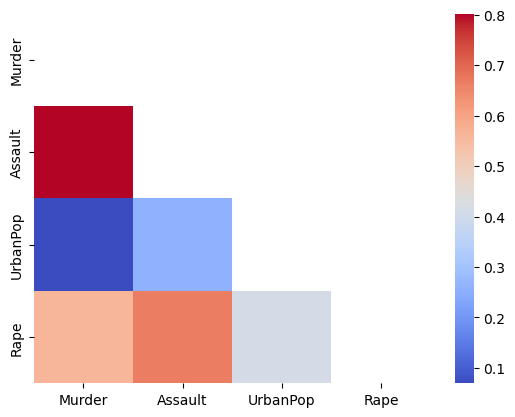

In [13]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")


From the correlation plot, it is evident that Murder has a relatively strong positive correlation to assault. Assault and rape are then probably second highest in correlation followed by Murder and Rape. It makes sense as to commit Murder requires an assault or assault is the precursor to murder. Assault and rape are also high and rape is sexual assault

conversely the urban population and murder has a low correlation as I would've guessed a more dense area would include perhaps more poverty/wealth divide and overcrowding with more daily pressures which may cause murder. it seems that murder is is capable by people regardless of the population

This makes the data a good candidate for PCA

In [15]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.drop(["City"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [16]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [17]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [18]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [41]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = countries[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()


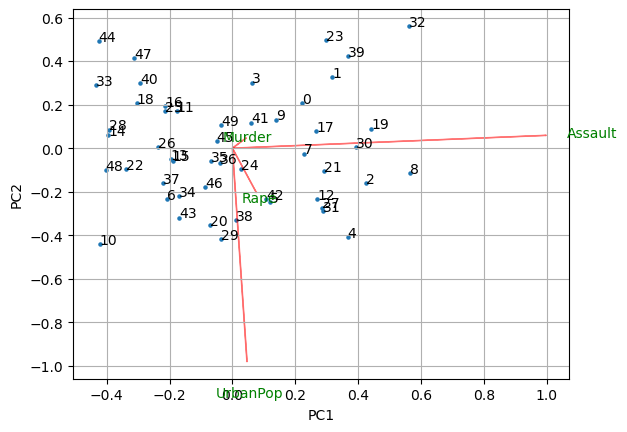

In [44]:

biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(countries))
plt.show()


From this biplot, we see that Arizona and Alaska are the most important features as the arrows to each of these dominate the biplot.

This information can also be quantified as follows:

In [43]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


We see that assault has by far the highest importance in the first principle component, while for the second component: urbanpop is the most important at close to 1, 0.977

These observations agree with those deduced from the biplot. If we refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

In [45]:
# standardise the data so that some features do not swamp the others

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


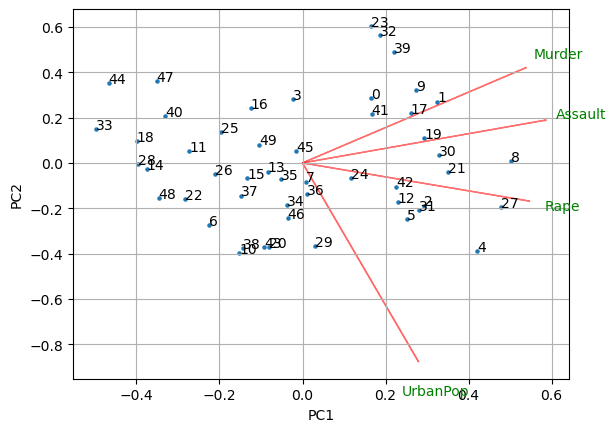

In [46]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it

In [47]:
# importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


inspecting the feature importance now, we see that most of the variables contribute fairly evenly. assault and urbanpop for pc1 and pc2 importance respectively are still above 0.5

Text(0.5, 1.0, 'Cumulative Explained Variance')

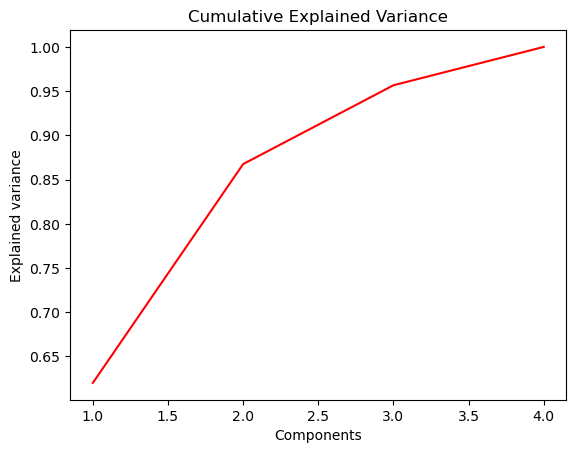

In [48]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

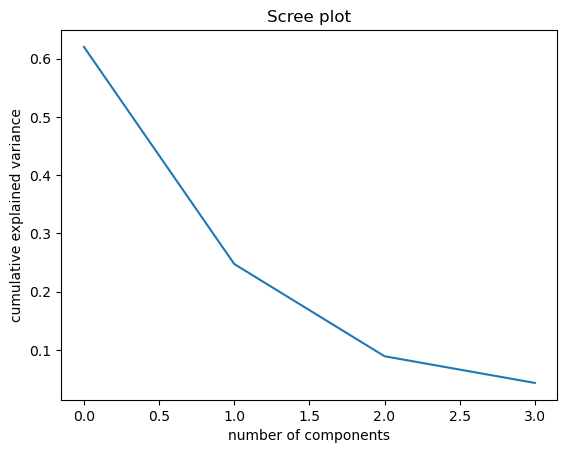

In [49]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 3 principal components together explain around 95% of the variance. We can therefore use them to perform cluster analysis. This is what we refer to as dimensionality reduction. We began with 4 variables and now we have 3 variables explaining most of the variability.

In [56]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
0,0.986,1.133,-0.444
1,1.950,1.073,2.040
2,1.763,-0.746,0.055
3,-0.141,1.120,0.115
4,2.524,-1.543,0.599


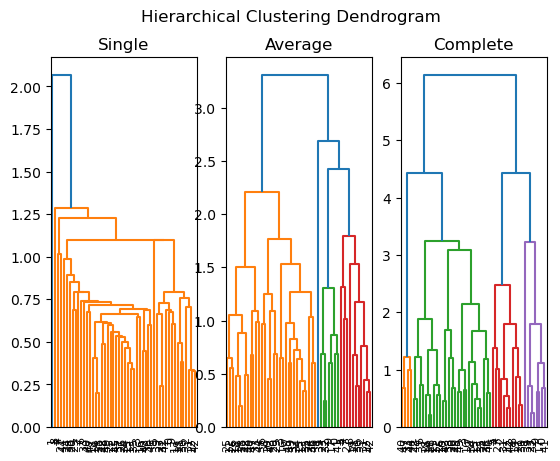

In [57]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

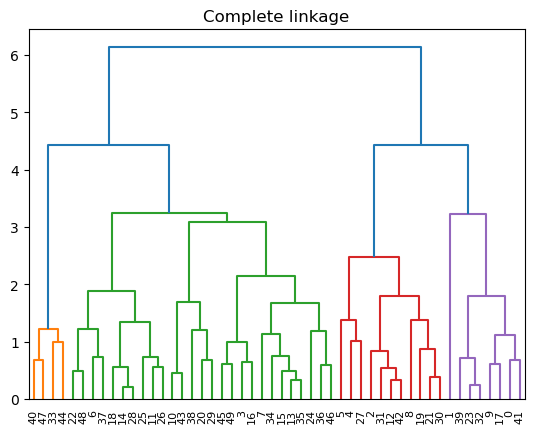

In [58]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

the clusters are of size 4, 27, 11, and 8 respectively.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


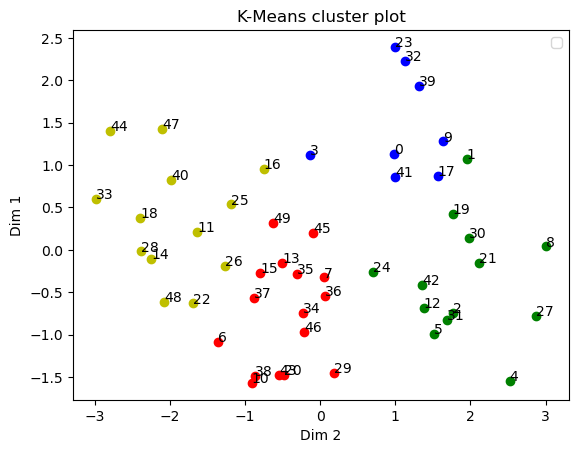

In [63]:
# for k means clustering
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = countries[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [64]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==3).transpose()[0]


group0 = np.array(countries)[group0_indices]
group1 = np.array(countries)[group1_indices]
group2 = np.array(countries)[group2_indices]
group3 = np.array(countries)[group3_indices]


print("Group 0: {}\n\n".format([df.loc[x]["City"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["City"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["City"] for x in group2]))
print("Group 3: {}\n\n".format([df.loc[x]["City"] for x in group3]))



Group 0: ['Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Massachusetts', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']


Group 1: ['Alabama', 'Arkansas', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


Group 2: ['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']


Group 3: ['Idaho', 'Iowa', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']




common between the two cluster methods are 4 distinct groups and by looking at each group you can see that states have similarities, for example group1 is a lot of southern belt countries

others may have unseen similarities such as certain laws or prohibitions on guns/drugs/social programs etc.